In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from model import *

from dataset import VNOnDBVocab
from torchvision import transforms
from system.utils import ScaleImageByHeight, Dilation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import ImageGrid
import skimage
import math
from PIL import ImageOps, Image

from dataset import CollateWrapper
from config import initialize, Config

In [2]:
device = 'cpu'
print('Device = {}'.format(device))

if True:
# if False:
    CKPT = '/home/aioz-intern-1/loi/runs/14-05-2020_11-38-31_vnondb_tf_en_petext_peimage_stn/weights/BEST.pt'
    print('Load weight from {}'.format(CKPT))
    checkpoint = torch.load(CKPT, map_location=device)
    config = checkpoint['config']
else:
    config = Config('./config/ce.yaml')
    config = config.config
config

Device = cpu
Load weight from /home/aioz-intern-1/loi/runs/14-05-2020_11-38-31_vnondb_tf_en_petext_peimage_stn/weights/BEST.pt


{'vocab': {'name': 'vnondb_vocab',
  'args': {'train_csv': 'data/VNOnDB/word/train_word.csv'}},
 'dataset': {'name': 'vnondb',
  'args': None,
  'scale_height': 96,
  'min_width': 7.0,
  'train': {'csv': 'data/VNOnDB/word/train_word_new.csv',
   'image_folder': 'data/VNOnDB/word/train_word'},
  'validation': {'csv': 'data/VNOnDB/word/validation_word_new.csv',
   'image_folder': 'data/VNOnDB/word/validation_word'},
  'test': {'csv': 'data/VNOnDB/word/test_word_new.csv',
   'image_folder': 'data/VNOnDB/word/test_word'}},
 'cnn': {'name': 'resnet', 'args': {'version': 'resnet50'}},
 'model': {'name': 'tf',
  'args': {'max_length': 15,
   'attn_size': 512,
   'nhead': 8,
   'dim_feedforward': 2048,
   'dropout': 0.1,
   'encoder_nlayers': 1,
   'decoder_nlayers': 1,
   'use_encoder': True,
   'use_pe_text': True,
   'use_pe_image': True,
   'use_stn': True}},
 'optimizer': {'name': 'adam', 'args': {'lr': 1e-05, 'weight_decay': 0}},
 'lr_scheduler': {'name': 'plateau',
  'args': {'mode': 'm

In [3]:
vocab = initialize(config['vocab'], add_blank=False)
cnn = initialize(config['cnn'])
model = initialize(config['model'], cnn, vocab)
model.load_state_dict(checkpoint['model'])
model.eval()
print('Ok')


image_transform = transforms.Compose([
    ImageOps.invert,
#     Dilation(3),
    ScaleImageByHeight(config['dataset']['scale_height'],
                       config['dataset']['min_width']),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

dataset = initialize(config['dataset'],
                     vocab=vocab,
                     image_transform=image_transform,
                     subset=False,
                     **config['dataset']['train'])

dataloader = torch.utils.data.DataLoader(dataset, 49,
                                         shuffle=False,
                                         collate_fn=lambda batch: CollateWrapper(batch))

Ok


In [4]:
named_modules = {}
def hook_weight_fn(module, inputs, outputs):
    named_modules[module]['output'] = outputs[1].cpu()

feature_size = tuple()
def hook_feature_size(module, inputs, outputs):
    global feature_size
    feature_size = outputs.shape

for name, module in model.named_modules():
    if isinstance(module, nn.MultiheadAttention) and 'multihead_attn' in name:
        named_modules[module] = {
            'name': name,
            'output': None,
        }
        module.register_forward_hook(hook_weight_fn)
    elif isinstance(module, (ResnetFE, DenseNetFE)):
        module.register_forward_hook(hook_feature_size)


In [5]:
iter_test_loader = iter(dataloader)

In [6]:
model.eval()
with torch.no_grad():
    batch = next(iter_test_loader)
    imgs, targets = batch.images.to(device), batch.labels.to(device)
    outputs = model.greedy(imgs)
    outputs, targets = outputs, targets[:, 1:]
    outputs = outputs.cpu()
    targets = targets.cpu()

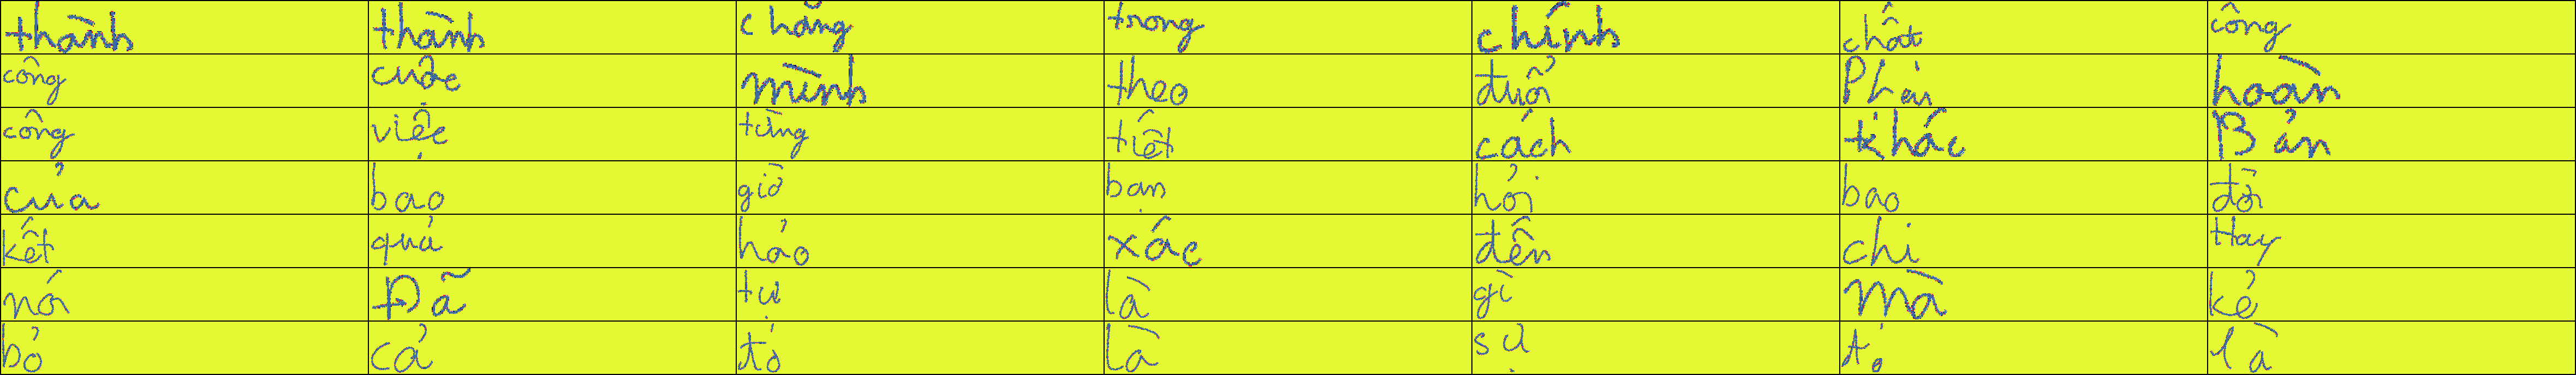

In [7]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs, nrow=7))

False


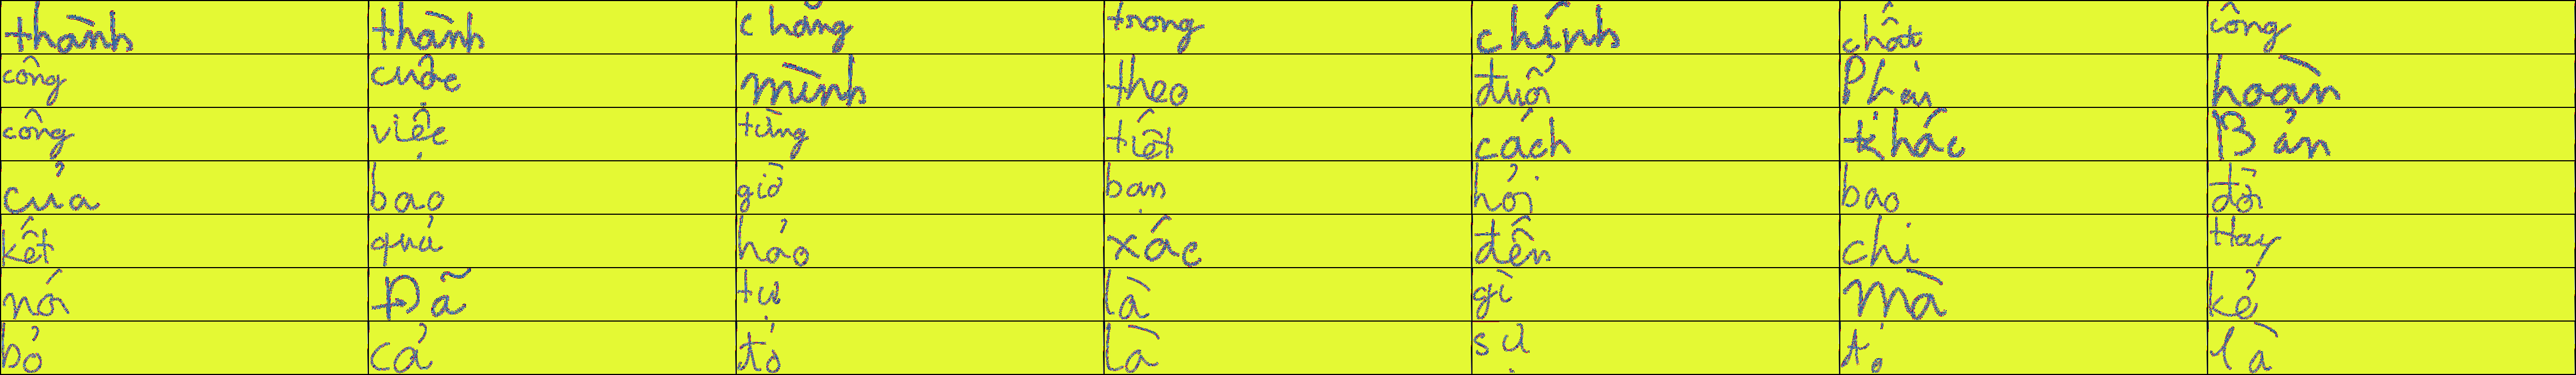

In [8]:
def f(images):
    bak_images = images
    images = model.stn(images)
    print(images.allclose(bak_images))
    images = torchvision.utils.make_grid(images, nrow=7)
    images = torchvision.transforms.ToPILImage()(images)
    return images
f(imgs)

In [9]:
for output in outputs.tolist():
    print(list(map(vocab.int2char, output)))

['t', 'h', 'à', 'n', 'h', '<end>']
['t', 'h', 'à', 'n', 'h', '<end>']
['c', 'h', 'ă', 'n', 'g', '<end>']
['t', 'r', 'o', 'n', 'g', '<end>']
['c', 'h', 'í', 'n', 'h', '<end>']
['c', 'h', 'ấ', 't', '<end>', '<end>']
['c', 'ô', 'n', 'g', '<end>', '<end>']
['c', 'ô', 'n', 'g', '<end>', '<end>']
['c', 'u', 'ộ', 'c', '<end>', '<end>']
['m', 'ì', 'n', 'h', '<end>', '<end>']
['t', 'h', 'e', 'o', '<end>', '<end>']
['đ', 'u', 'ổ', 'i', '<end>', '<end>']
['P', 'h', 'ả', 'i', '<end>', '<end>']
['h', 'o', 'à', 'n', '<end>', '<end>']
['c', 'ô', 'n', 'g', '<end>', '<end>']
['v', 'i', 'ệ', 'c', '<end>', '<end>']
['t', 'ừ', 'n', 'g', '<end>', '<end>']
['t', 'i', 'ế', 't', '<end>', '<end>']
['c', 'á', 'c', 'h', '<end>', '<end>']
['k', 'h', 'á', 'c', '<end>', '<end>']
['B', 'ả', 'n', '<end>', '<end>', '<end>']
['c', 'ủ', 'a', '<end>', '<end>', '<end>']
['b', 'a', 'o', '<end>', '<end>', '<end>']
['g', 'i', 'ờ', '<end>', '<end>', '<end>']
['b', 'ạ', 'n', '<end>', '<end>', '<end>']
['h', 'ỏ', 'i', '<end>', 

In [ ]:
print(feature_size)
B,C,H,W = feature_size

for i, (key, value) in enumerate(named_modules.items()):
    weight = value['output'] # [B, T, S]
    T = weight.size(1)
    figure, axes = plt.subplots(T, B, squeeze=False, figsize=(20,5))
    weight = weight.reshape(-1,W,H)
    weight = weight.transpose(-1, -2)
    for j, w in enumerate(weight):
        # w: [H,W]
        pil_image = torchvision.utils.make_grid(w.unsqueeze(0), nrow=T)
        axes[j%T, j//T].imshow(pil_image[0])
    break

torch.Size([49, 512, 12, 84])
